In [ ]:
# save 2 files 1 for training the other for testing
# plot each activity count
# boxplot the activities, one plot for gyro one plot for accel

In [11]:
import numpy as np
import pandas as pd
#pd.options.display.float_format = '{:.6f}'.format

import os
from time import time
from datetime import datetime as dt
import pickle
from scipy.stats import stats # for moments
from collections import defaultdict
from scipy.fftpack import rfft # only interested in real-value results
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

!matplotlib inline

/bin/bash: matplotlib: command not found


In [12]:
!pip install pyarrow

In [13]:
df = pd.read_parquet('classifyactivities.parquet', engine='pyarrow')

In [14]:
df.z= df.z.astype(float)#previously noted z was object, changed it to float
activities= {'A':'walking','B':'jogging','C':'stairs','D':'sitting','E':'standing','F':'typing','G':'teeth','H':'soup','I':'chips'
             ,'J':'pasta','K':'drinking','L':'sandwich','M':'kicking','O':'catch','P':'dribling','Q':'writing','R':'clapping',
             'S':'folding'}
df = df.replace({'activity':activities})

df.head()

,subjectid,activity,timestamp,x,y,z,type,device
0,1639,walking,1.849641e+14,8.288427,-4.857087,9.167398,phone,accel
1,1639,walking,1.849642e+14,14.506168,-13.624654,14.149732,phone,accel
2,1639,walking,1.849642e+14,8.800786,-3.229030,4.376601,phone,accel
3,1639,walking,1.849643e+14,18.195633,-11.740417,0.481235,phone,accel
4,1639,walking,1.849643e+14,16.316185,-3.992780,-0.986411,phone,accel


In [15]:
df.shape

(15630426, 8)

In [16]:
#format since data was displaying scientific notation
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,subjectid,timestamp,x,y,z
count,15630426.000000,15630426.000000,15630426.000000,15630426.000000,15630426.000000
mean,1626.266503,590447296652959.750000,0.129160,-1.607849,0.557048
std,14.788170,603445698477162.875000,4.792884,5.025267,3.970900
min,1600.000000,268102711042.000000,-78.477610,-78.477610,-78.477610
25%,1614.000000,107914533221983.000000,-1.423934,-4.157089,-0.640274
50%,1627.000000,370481792926658.000000,-0.001968,-0.129028,0.004527
75%,1639.000000,940768274718381.500000,1.293311,0.121321,1.786685
max,1650.000000,2724599224330653.000000,78.477610,64.411660,69.081950


In [17]:
#check if there is missing data
df.isnull().sum()

subjectid    0
activity     0
timestamp    0
x            0
y            0
z            0
type         0
device       0
dtype: int64

x,y,z units are
m/s2
, while for the gyroscope sensor, the units are
radians/s. Note that the force of gravity on Earth,
which affects the accelerometer readings, is 9.8m/s2



### Check data qty for each activity

drinking    901381
walking     886762
dribling    882716
standing    882587
kicking     882417
sitting     875030
folding     872243
teeth       871710
writing     871159
clapping    869905
soup        869704
catch       868766
jogging     862281
chips       861398
sandwich    857571
stairs      841230
pasta       840358
typing      833208
Name: activity, dtype: int64


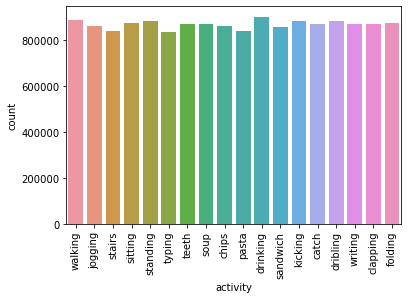

In [18]:
labels= df['activity']
print(labels.value_counts())
sns.countplot(labels)
plt.xticks(rotation= 90)
plt.show()

It can be appreciated that each activity has about the same amount of data, the bottom 3(typing, pasta,stairs) are the one with the most imbalance

In [19]:
#We will focus on five activities
min_activities = '"walking","jogging","standing","sitting","dribling"'
df = df.query('activity in ('+min_activities+') & type=="watch" ' )

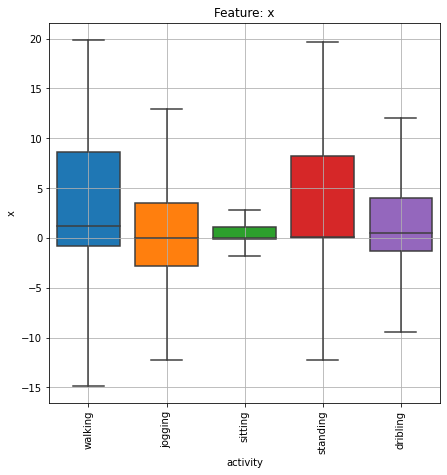

In [20]:
# feature : 'x'
# we will plot box and whisker plot for the univariate analysis
plt.figure(figsize= (7, 7))
sns.boxplot(x='activity', y='x',data=df, showfliers=False, saturation=1)
plt.title('Feature: x')
plt.xticks(rotation= 90)
plt.grid()

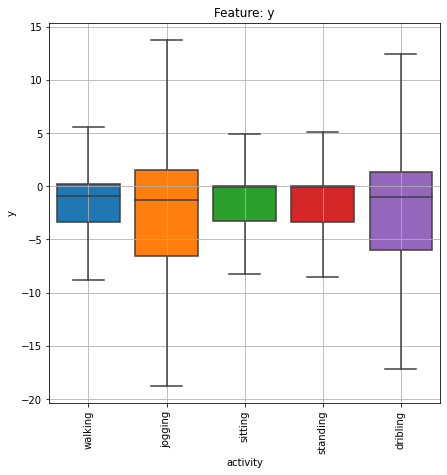

In [21]:
# feature : 'y'
# we will plot box and whisker plot for the univariate analysis
plt.figure(figsize= (7, 7))
sns.boxplot(x='activity', y='y',data=df, showfliers=False, saturation=1)
plt.title('Feature: y')
plt.xticks(rotation= 90)
plt.grid()

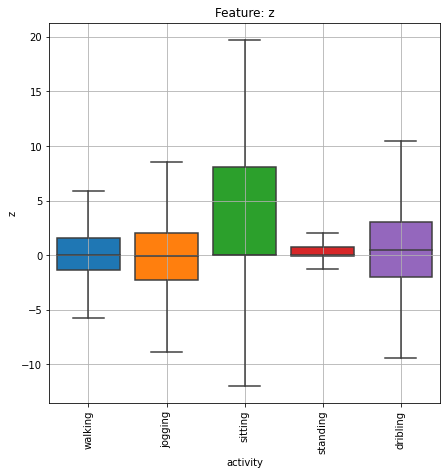

In [22]:
# feature : 'z'
# we will plot box and whisker plot for the univariate analysis
plt.figure(figsize= (7, 7))
sns.boxplot(x='activity', y='z',data=df, showfliers=False, saturation=1)
plt.title('Feature: z')
plt.xticks(rotation= 90)
plt.grid()

In [23]:
from sklearn.manifold import TSNE

def perform_tsne(x_train, y_train, perplexities, n_iter= 300):
  for index, per in enumerate(perplexities):
    print('Performing TSNE with perplexity {} and iterations {}'.format(per, n_iter))
    x_reduced= TSNE(verbose= 1, perplexity= per).fit_transform(x_train)
    print('done...')

    df_sne= pd.DataFrame({'x':x_reduced[:,0], 'y':x_reduced[:,1], 'label':y_train})
    print('creating plot for TSNE visualization..')
    plt.figure(figsize= (7, 7))
    sns.lmplot(data= df_sne, x= 'x', y= 'y', hue= 'label', fit_reg=False, palette= 'Set1', markers=['^','v','s','o', '1'])
    plt.title("perplexity : {} and max_iter : {}".format(per, n_iter))
    img_name = 'tsne' + '_perp_{}_iter_{}.png'.format(per, n_iter)

    print('saving this plot as image in present working directory...')
    plt.savefig(img_name)

In [ ]:
current_df = df

y_pre_tsne = current_df['activity']
X_pre_tsne = current_df.drop(['type','activity','device'], axis=1)
perform_tsne(X_pre_tsne, y_pre_tsne, perplexities =[2,5,10,20,50])


Performing TSNE with perplexity 2 and iterations 300
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 2023001 samples in 1080.617s...
[t-SNE] Computed neighbors for 2023001 samples in 17.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2023001
[t-SNE] Computed conditional probabilities for sample 2000 / 2023001
[t-SNE] Computed conditional probabilities for sample 3000 / 2023001
[t-SNE] Computed conditional probabilities for sample 4000 / 2023001
[t-SNE] Computed conditional probabilities for sample 5000 / 2023001
[t-SNE] Computed conditional probabilities for sample 6000 / 2023001
[t-SNE] Computed conditional probabilities for sample 7000 / 2023001
[t-SNE] Computed conditional probabilities for sample 8000 / 2023001
[t-SNE] Computed conditional probabilities for sample 9000 / 2023001
[t-SNE] Computed conditional probabilities for sample 10000 / 2023001
[t-SNE] Computed conditional probabilities for sample 11000 / 2023001
[t-SNE] Computed conditional probabi